In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import pickle
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.cross_decomposition import PLSRegression 
from sklearn.model_selection import cross_val_predict, LeaveOneOut, StratifiedKFold, cross_val_score
import copy
import time
import pandas as pd
from sklearn.utils import shuffle
from seaborn import distplot, histplot

In [2]:
with open('data/FC_Hist_avg/fmri_paper_subjects_141ROI_hist_A2009_bandpass_fisher_z_2890.pickle', 'rb') as handle:      
    all_sub_hist = pickle.load(handle)

sub_det_df = pd.read_excel('data/rs_fmri_sub_details_all.xlsx')
cur_sub_list_before = sub_det_df['Subject_ID_before'].to_numpy()
cur_sub_list_after = sub_det_df['Subject_ID_after'].to_numpy()
age = sub_det_df['age'].to_numpy()
sex = sub_det_df['sex'].to_numpy()
sub_labels = sub_det_df['sub_labels'].to_numpy()
labels = sub_det_df['labels'].to_numpy()
mean_motion_before = sub_det_df['mean_motion_before'].to_numpy()
mean_motion_after = sub_det_df['mean_motion_after'].to_numpy()

loo = LeaveOneOut()    
skf = StratifiedKFold(n_splits=6)
hist_len = len(all_sub_hist['BG_04_01'][10,10])
ap,step = np.linspace(-1,1,hist_len+1,retstep = True )
bin_centre = ap[:-1] + step/2 
y_categorical = ['IBS','HC']
mks = ['o','^']    
imp_roi = np.array([10,11,12,13,17,18,49,50,51,52,53,54,
            11101, 11102, 11104, 11105, 11106, 11107, 11108, 11109, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120,
            11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11133, 11134, 11135, 11136, 11137, 11138, 11141, 11143,
            11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11153, 11154, 11155, 11157, 11158, 11159, 11160, 11161, 11162, 11164, 11165, 11166, 11167,
            11168, 11169, 11170, 11171, 11172, 11173, 11174, 
            12101, 12102, 12104, 12105, 12106, 12107, 12108, 12109, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120,
            12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12133, 12134, 12135, 12136, 12137, 12138, 12141, 12143, 12144,
            12145, 12146, 12147, 12148, 12149, 12150, 12151, 12153, 12154, 12155, 12157, 12158, 12159, 12160, 12161, 12162, 12164, 12165, 12166, 12167,
            12168, 12169, 12170, 12172, 12173, 12174])

roi_pair_dict = {}
no_pairs = 0
imp_roi1 = [11117,12117,11118,12118,11148,12148,11149,12149,11150,12150] #insula sub-regions
for i,roi1 in enumerate(imp_roi1):
    for j,roi2 in enumerate(imp_roi):
        if not (roi2 in imp_roi1):
            if(roi1<roi2):
                roi_pair_dict[no_pairs] = [roi1,roi2]
            else:
                roi_pair_dict[no_pairs] = [roi2,roi1]
            no_pairs = no_pairs+1
        else:
            if(roi1<roi2):
                roi_pair_dict[no_pairs] = [roi1,roi2]
                no_pairs = no_pairs+1        
print(no_pairs)

# RIO region-names as per freesurfer
all_parc = {}
with open('data/all_parc.txt', 'r') as f:
    x = f.readlines()
for i in range(0,len(x)):
    temp = x[i].split()
    all_parc[int(temp[0])] = temp[1]

1355


In [3]:
# for each ROI-ROI pait construct data matrix X-(both before and after), X1-(before), X2-(after) 
all_feature_set = {}
all_feature_set_before = {}
all_feature_set_after = {}
for count in range(no_pairs):  
    sele_roi = roi_pair_dict[count][0]
    sele_roi1 = roi_pair_dict[count][1]
    X1 = np.zeros((len(labels),hist_len))
    X2 = np.zeros((len(labels),hist_len))
    X = np.zeros((len(labels),hist_len*2))
    for j,sub_id in enumerate(cur_sub_list_before):
        X[j,0:50] = all_sub_hist[sub_id][sele_roi,sele_roi1]
        X[j,50:] = all_sub_hist[cur_sub_list_after[j]][sele_roi,sele_roi1]
        X1[j,:] = all_sub_hist[sub_id][sele_roi,sele_roi1]
        X2[j,:] = all_sub_hist[cur_sub_list_after[j]][sele_roi,sele_roi1]
    all_feature_set[count] = X
    all_feature_set_before[count] = X1
    all_feature_set_after[count] = X2

In [5]:
def custum_scores(pls2, X, y):
    y_hat = np.ones(len(y))
    y_hat[y == -1] = 0
    return balanced_accuracy_score(y_hat, pls2.predict(X)>0)

In [6]:
def run_onefold_LOO(all_feature_set_temp,train_index,test_index,labels, roi_pair_dict, no_comp):
    label_train = labels[train_index]
    label_test = labels[test_index]
    y_pls = np.ones(len(label_train))
    y_pls[label_train == 0] = -1
    all_cv_scores = np.zeros(len(all_feature_set_temp))
    all_cv_np_comp = np.zeros(len(all_feature_set_temp),dtype = int)
    
    for i in range(len(all_feature_set_temp)):#all_feature_set:       
        X = all_feature_set_temp[i]
        X_train = X[train_index,:]
        cv_scores = cross_val_score(PLSRegression(n_components=no_comp, scale = False), X_train, y_pls, cv=skf, scoring = custum_scores)
        all_cv_scores[i] = np.mean(cv_scores)
#         cv_predict = cross_val_predict(PLSRegression(n_components=no_comp, scale = False), X_train, y_pls, cv=LeaveOneOut())
#         all_cv_scores[i] = balanced_accuracy_score(label_train,cv_predict>0)
        
    sort_arg = np.argsort(all_cv_scores)
    no_feu_to_sel = 3
    y_pred_final = 0
    
    X = all_feature_set_temp[sort_arg[-1]]
    pls2 = PLSRegression(n_components=no_comp, scale = False).fit(X[train_index,:],y_pls)        
    yemp_y = pls2.predict(X[test_index,:])    
    if(yemp_y>0):
        y_pred_final1 = 1
    else:
        y_pred_final1 = 0
        
#     print(int(label_test[0]),'--->', y_pred_final1)
#     print('--------------')
    return(y_pred_final1,sort_arg[-1])

In [31]:
start = time.time()
y_pred = []
y_actual = []
y_pred_before = []
y_pred_after = []
count = 0
top_roi_loc = np.zeros(len(labels))
top_roi_loc_before = np.zeros(len(labels))
top_roi_loc_after = np.zeros(len(labels))

for train_index, test_index in loo.split(labels):
    hahaha, top_roi_loc[count] = run_onefold_LOO(all_feature_set,train_index,test_index,labels, roi_pair_dict, 5)
    hahaha1, top_roi_loc_before[count] = run_onefold_LOO(all_feature_set_before,train_index,test_index,labels, roi_pair_dict, 5)
    hahaha2, top_roi_loc_after[count] = run_onefold_LOO(all_feature_set_after,train_index,test_index,labels, roi_pair_dict, 5)
    y_actual.append(labels[test_index][0])
    y_pred.append(hahaha)
    y_pred_before.append(hahaha1)
    y_pred_after.append(hahaha2)
    count = count + 1
print('--Finished--')

--Finished--


In [40]:
BA_pipeline_combined = balanced_accuracy_score(y_actual, y_pred)
BA_pipeline_before = balanced_accuracy_score(y_actual, y_pred_before)
BA_pipeline_after = balanced_accuracy_score(y_actual, y_pred_after)
# print(BA,BA_before,BA_after)
print('Balanced accuracy Combined:',BA_pipeline_combined)
print('Balanced accuracy Before:',BA_pipeline_before)
print('Balanced accuracy After:',BA_pipeline_after)
LOO_pipeline_predictions = {}
LOO_pipeline_predictions['combined'] = y_pred
LOO_pipeline_predictions['before'] = y_pred_before
LOO_pipeline_predictions['after'] = y_pred_after 
with open('data/FC_Hist_avg/LOO_pipeline_predictions.pickle', 'wb') as handle:
    pickle.dump(LOO_pipeline_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

Balanced accuracy Combined: 0.7933673469387755
Balanced accuracy Before: 0.4017857142857143
Balanced accuracy After: 0.6311224489795919


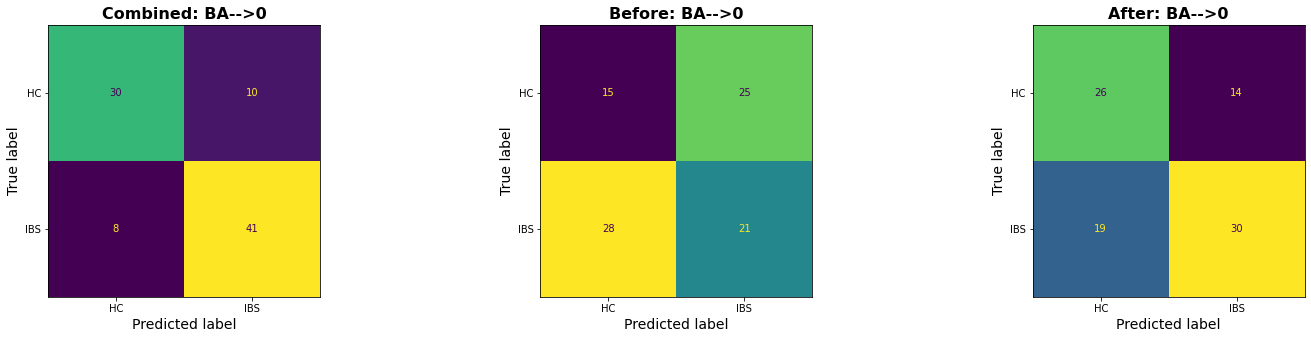

In [29]:
fix, axs = plt.subplots(1,3,figsize = (25,5))  
aa = ConfusionMatrixDisplay.from_predictions(y_actual, y_pred, colorbar = False, display_labels=('HC','IBS'), ax = axs[0])
aa = ConfusionMatrixDisplay.from_predictions(y_actual, y_pred_before, colorbar = False, display_labels=('HC','IBS'), ax = axs[1])
aa = ConfusionMatrixDisplay.from_predictions(y_actual, y_pred_after, colorbar = False, display_labels=('HC','IBS'), ax = axs[2])
aa = axs[0].set_title('Combined: BA-->%d'%BA, fontsize=16, fontweight = 'bold')
aa = axs[1].set_title('Before: BA-->%d'%BA_before, fontsize=16, fontweight = 'bold')
aa = axs[2].set_title('After: BA-->%d'%BA_after, fontsize=16, fontweight = 'bold')
aa = axs[0].set_xlabel('Predicted label', fontsize=14)
aa = axs[1].set_xlabel('Predicted label', fontsize=14)
aa = axs[2].set_xlabel('Predicted label', fontsize=14)
aa = axs[0].set_ylabel('True label', fontsize=14)
aa = axs[1].set_ylabel('True label', fontsize=14)
aa = axs[2].set_ylabel('True label', fontsize=14)

In [11]:
unique_combined, combined_counts = np.unique(top_roi_loc, return_counts=True)
unique_before, before_counts = np.unique(top_roi_loc_before, return_counts=True)
unique_after, after_counts = np.unique(top_roi_loc_after, return_counts=True)
print('combined:')
print(all_parc[roi_pair_dict[unique_combined[0]][0]],'----->',all_parc[roi_pair_dict[unique_combined[0]][1]], 'Counts:', combined_counts[0])
print('-------------')

print('before:')
for i in range(len(unique_before)):
    print(all_parc[roi_pair_dict[unique_before[i]][0]],'----->',all_parc[roi_pair_dict[unique_before[i]][1]], 'Counts:', before_counts[i])
print('-------------')
print('after:')
for i in range(len(unique_after)):
    print(all_parc[roi_pair_dict[unique_after[i]][0]],'----->',all_parc[roi_pair_dict[unique_after[i]][1]], 'Counts:', after_counts[i])

combined:
ctx_lh_S_circular_insula_inf -----> ctx_rh_S_circular_insula_ant Counts: 89
-------------
before:
ctx_lh_G_Ins_lg_and_S_cent_ins -----> ctx_lh_G_temp_sup-Lateral Counts: 1
ctx_rh_G_Ins_lg_and_S_cent_ins -----> ctx_rh_S_oc-temp_med_and_Lingual Counts: 1
ctx_lh_G_insular_short -----> ctx_rh_G_front_inf-Triangul Counts: 1
ctx_lh_G_insular_short -----> ctx_rh_S_oc-temp_med_and_Lingual Counts: 1
ctx_lh_Lat_Fis-post -----> ctx_rh_G_insular_short Counts: 1
ctx_lh_S_oc-temp_med_and_Lingual -----> ctx_rh_G_insular_short Counts: 1
Left-Putamen -----> ctx_lh_S_circular_insula_ant Counts: 1
ctx_lh_S_circular_insula_ant -----> ctx_lh_S_temporal_inf Counts: 4
ctx_lh_S_circular_insula_ant -----> ctx_rh_G_front_sup Counts: 2
ctx_lh_G_rectus -----> ctx_rh_S_circular_insula_ant Counts: 6
ctx_lh_S_front_middle -----> ctx_rh_S_circular_insula_ant Counts: 17
ctx_lh_S_circular_insula_inf -----> ctx_rh_G_oc-temp_med-Parahip Counts: 35
ctx_lh_S_circular_insula_inf -----> ctx_rh_S_circular_insula_ant

In [15]:
top_ROI_all = np.unique([unique_combined[np.argmax(combined_counts)], unique_before[np.argmax(before_counts)],
                        unique_after[np.argmax(after_counts)]])
print(top_ROI_all)

[912. 933.]


In [17]:
select_mat_combined = {}
select_mat_before = {}
select_mat_after = {}
y_pls_all = np.ones(len(labels))
y_pls_all[labels == 0] = -1

for i in range(len(top_ROI_all)):
    select_mat_before[i] = all_feature_set_before[top_ROI_all[i]]
    select_mat_after[i] = all_feature_set_after[top_ROI_all[i]]
    select_mat_combined[i] = all_feature_set[top_ROI_all[i]]

In [39]:
BA_combined = np.zeros(len(top_ROI_all))
BA_before = np.zeros(len(top_ROI_all))
BA_after = np.zeros(len(top_ROI_all))

for i in range(len(top_ROI_all)):
    cv_pred_c = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_combined[i], y_pls_all, cv=loo)
    BA_combined[i] = balanced_accuracy_score(labels,cv_pred_c>0)
    cv_pred_b = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_before[i], y_pls_all, cv=loo)
    BA_before[i] = balanced_accuracy_score(labels,cv_pred_b>0)
    cv_pred_a = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_after[i], y_pls_all, cv=loo)
    BA_after[i] = balanced_accuracy_score(labels,cv_pred_a>0)
    
    print(all_parc[roi_pair_dict[top_ROI_all[i]][0]],'----->',all_parc[roi_pair_dict[top_ROI_all[i]][1]])
    print('Balanced accuracy Combined:',BA_combined[i])
    print('Balanced accuracy Before:',BA_before[i])
    print('Balanced accuracy After:',BA_after[i])
    print('--------------------------------------')

ctx_lh_S_circular_insula_inf -----> ctx_rh_G_oc-temp_med-Parahip
Balanced accuracy Combined: 0.4653061224489796
Balanced accuracy Before: 0.6775510204081632
Balanced accuracy After: 0.47551020408163264
--------------------------------------
ctx_lh_S_circular_insula_inf -----> ctx_rh_S_circular_insula_ant
Balanced accuracy Combined: 0.7933673469387755
Balanced accuracy Before: 0.6423469387755103
Balanced accuracy After: 0.7071428571428571
--------------------------------------


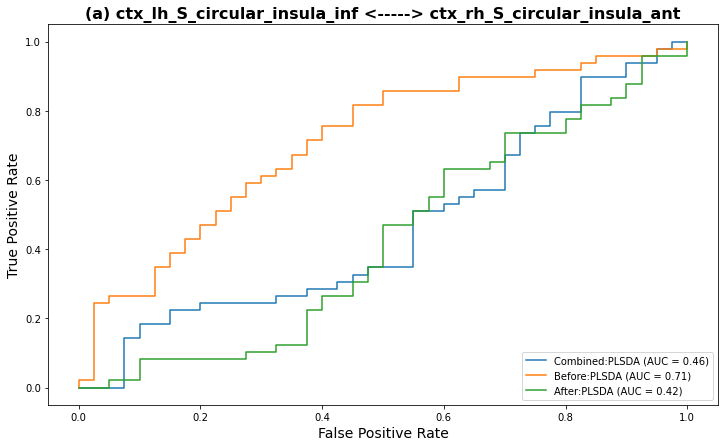

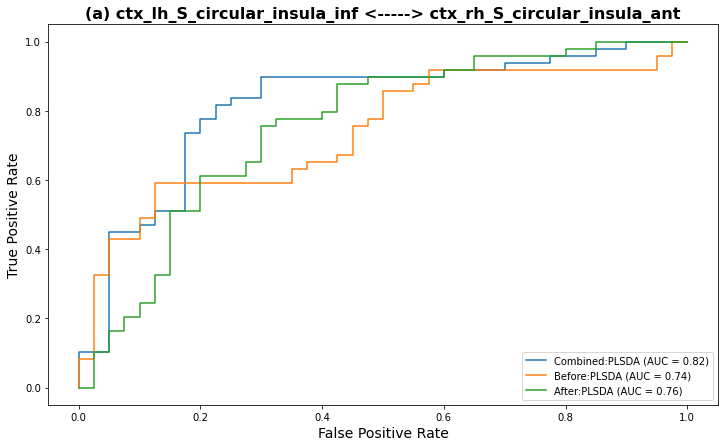

In [35]:
for i in range(len(top_ROI_all)):
    cv_pred_c = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_combined[i], y_pls_all, cv=loo)
    BA_combined = balanced_accuracy_score(labels,cv_pred_c>0)
    cv_pred_b = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_before[i], y_pls_all, cv=loo)
    BA_before = balanced_accuracy_score(labels,cv_pred_b>0)
    cv_pred_a = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_after[i], y_pls_all, cv=loo)
    BA_after = balanced_accuracy_score(labels,cv_pred_a>0)
    
    fig = plt.figure(figsize = (12,7))
    ax = plt.gca()
    RocCurveDisplay.from_predictions(y_pls_all, cv_pred_c, name = 'Combined:PLSDA', ax = ax)
    RocCurveDisplay.from_predictions(y_pls_all, cv_pred_b, name = 'Before:PLSDA', ax = ax)
    RocCurveDisplay.from_predictions(y_pls_all, cv_pred_a, name = 'After:PLSDA', ax = ax)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('(a) ctx_lh_S_circular_insula_inf <-----> ctx_rh_S_circular_insula_ant', fontsize=16, fontweight = 'bold')
    plt.savefig('/data-braingut/bharath/paper_figuers/ROC_curce', dpi=300)
    plt.show()

In [49]:
np_runs = 10000

all_cv_score = {}
all_cv_score_before = {}
all_cv_score_after = {}

for i in range(len(top_ROI_all)):
    all_cv_score[i] = np.zeros(np_runs)
    all_cv_score_before[i] = np.zeros(np_runs)
    all_cv_score_after[i] = np.zeros(np_runs)


for i in range(np_runs):
    labels_perm = shuffle(labels, random_state = i)
    y_pls_perm = np.ones_like(labels)
    y_pls_perm[labels_perm == 0] = -1
    
    for j in range(len(top_ROI_all)):
        cv_pred_c_perm = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_combined[j], y_pls_perm, cv=loo)
        all_cv_score[j][i] = balanced_accuracy_score(labels_perm,cv_pred_c_perm>0)

        cv_pred_b_perm = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_before[j], y_pls_perm, cv=loo)
        all_cv_score_before[j][i] = balanced_accuracy_score(labels_perm,cv_pred_b_perm>0)

        cv_pred_a_perm = cross_val_predict(PLSRegression(n_components=5, scale = False), select_mat_after[j], y_pls_perm, cv=loo)
        all_cv_score_after[j][i] = balanced_accuracy_score(labels_perm,cv_pred_a_perm>0)
    
    
    if((i+1)%1000 == 0):
        print(i)

999
1999
2999
3999
4999
5999
6999
7999
8999
9999


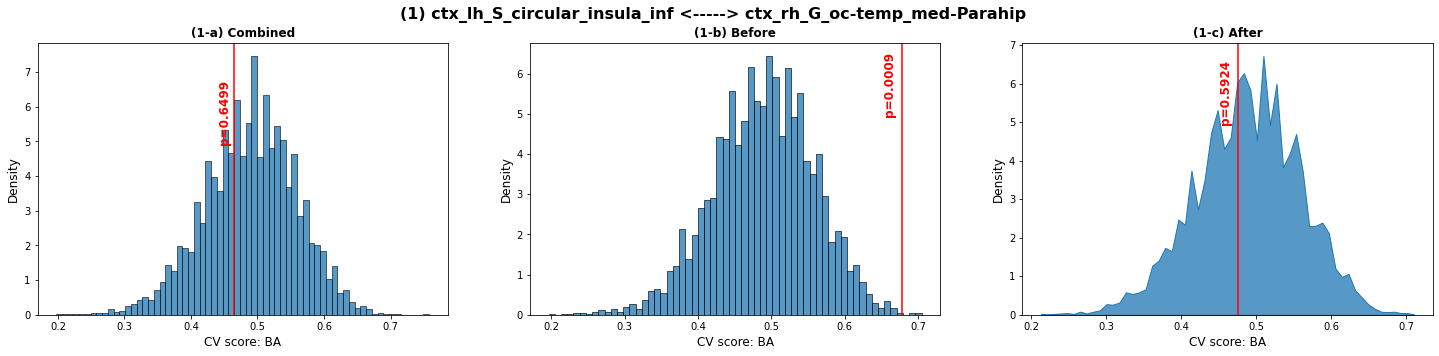

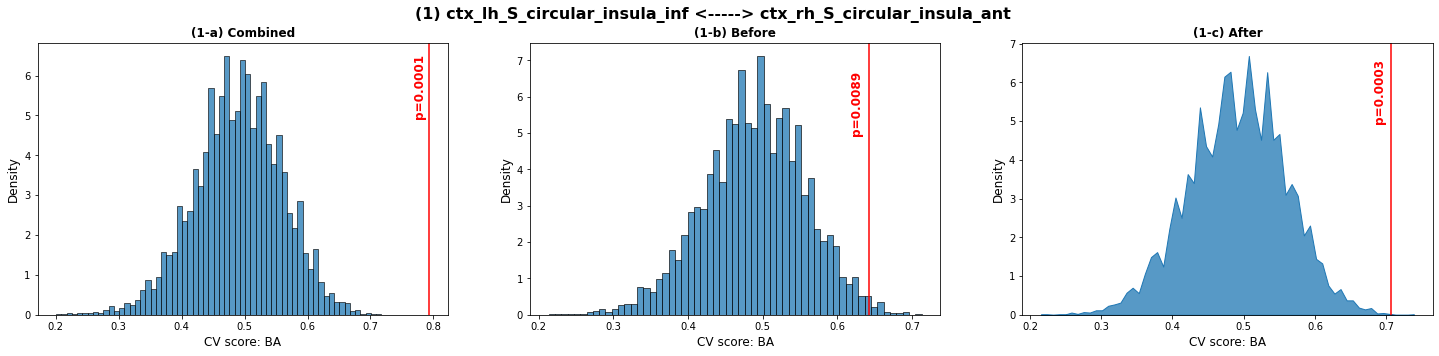

In [56]:
for j in range(len(top_ROI_all)):
    p_c = (np.sum(all_cv_score[j] >= BA_combined[j])+1)/(np_runs+1)
    p_b = (np.sum(all_cv_score_before[j] >= BA_before[j])+1)/(np_runs+1)
    p_a = (np.sum(all_cv_score_after[j] >= BA_after[j])+1)/(np_runs+1)

    fix, axs = plt.subplots(1,3,figsize = (25,5))  

#     ptax1 = distplot(all_cv_score[j], ax = axs[0], norm_hist = True)
    ptax1 = histplot(all_cv_score[j], ax = axs[0], stat = 'density')
    
    ptax1.axvline(x = BA_combined[j], c = 'r')
    ptax1.text(BA_combined[j]-0.025,5,s = 'p=%.4f'%p_c, c= 'r', rotation = 'vertical', fontweight = 'bold', fontsize = 'large')
    ptax1.set_title('(1-a) Combined', fontweight = 'bold')
    ptax1.set_xlabel('CV score: BA', fontsize = 'large')
    ptax1.set_ylabel('Density', fontsize = 'large')

#     ptax2 = distplot(all_cv_score_before[j], ax = axs[1], norm_hist = True)
    ptax2 = histplot(all_cv_score_before[j], ax = axs[1], stat = 'density')
    
    ptax2.axvline(x = BA_before[j], c = 'r')
    ptax2.text(BA_before[j]-0.025,5,s = 'p=%.4f'%p_b, c= 'r', rotation = 'vertical', fontweight = 'bold', fontsize = 'large')
    ptax2.set_title('(1-b) Before', fontweight = 'bold')
    ptax2.set_xlabel('CV score: BA', fontsize = 'large')
    ptax2.set_ylabel('Density', fontsize = 'large')

#     ptax3 = distplot(all_cv_score_after[j], ax = axs[2], norm_hist = True)
    ptax3 = histplot(all_cv_score_after[j], ax = axs[2], stat = 'density', element = 'poly')
    
    ptax3.axvline(x = BA_after[j], c = 'r')
    ptax3.text(BA_after[j]-0.025,5,s = 'p=%.4f'%p_a, c= 'r', rotation = 'vertical', fontweight = 'bold', fontsize = 'large')
    ptax3.set_title('(1-c) After', fontweight = 'bold')
    ptax3.set_xlabel('CV score: BA', fontsize = 'large')
    ptax3.set_ylabel('Density', fontsize = 'large')

    fix.suptitle('(1) %s <-----> %s'%(all_parc[roi_pair_dict[top_ROI_all[j]][0]],all_parc[roi_pair_dict[top_ROI_all[j]][1]]),
                 fontsize=16, fontweight = 'bold')
#     plt.savefig('/data-braingut/bharath/paper_figuers/PT_all', dpi=300)